<a href="https://colab.research.google.com/github/hargurjeet/LJMU_Thesis/blob/main/ExperimentThresholdAdjustments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hargurjeet/LJMU_Thesis.git

Cloning into 'LJMU_Thesis'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 152 (delta 84), reused 8 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 10.91 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [2]:
!pip install pandas openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## Open AI experiments

In [4]:
# df_open_ai = pd.read_csv("/content/LJMU_Thesis/Processed_output/openai_generated_output.csv")
# df_open_ai.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target,TextualData
0,34,No,Middle Income,6,No,Yes,0,The customer is 34 years old and has indicated...
1,34,Yes,Low Income,5,Yes,No,1,The customer is aged 34 and is a frequent flye...
2,37,No,Middle Income,3,Yes,No,0,The customer is 37 years old and is not a freq...
3,30,No,Middle Income,2,No,No,0,The customer is aged 30 and is not a frequent ...
4,30,No,Low Income,1,No,No,0,"The customer is 30 years old, does not frequen..."


## Generating embeddings for OpenAI model

In [6]:
import openai

openai.api_key = ''

In [4]:
# def get_embedding(text):
#     response = openai.Embedding.create(
#         model="text-embedding-ada-002",
#         input=text
#     )
#     return response['data'][0]['embedding']

# df_open_ai['Embedding'] = df_open_ai['TextualData'].apply(get_embedding)

In [40]:
# df_open_ai.to_parquet('openai_embeddings.parquet', index=False)

parquet_file_path = '/content/LJMU_Thesis/Processed_output/openai_embeddings.parquet'
df_open_ai = pd.read_parquet(parquet_file_path)

In [ ]:
import matplotlib.pyplot as plt
# Prepare data
X = df_open_ai['Embedding'].tolist()
y = df_open_ai['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

## Training models

In [41]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_open_ai['Embedding'].tolist(),
    df_open_ai['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       153
           1       0.73      0.21      0.33        38

    accuracy                           0.83       191
   macro avg       0.78      0.60      0.61       191
weighted avg       0.81      0.83      0.79       191



In [42]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model.fit(X_train_pca, y_train)
y_pred = xgb_model.predict(X_test_pca)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       153
           1       0.67      0.47      0.55        38

    accuracy                           0.85       191
   macro avg       0.77      0.71      0.73       191
weighted avg       0.84      0.85      0.84       191



## Threshold experiment with XGB classifier

In [ ]:
y_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

## Building Visuals

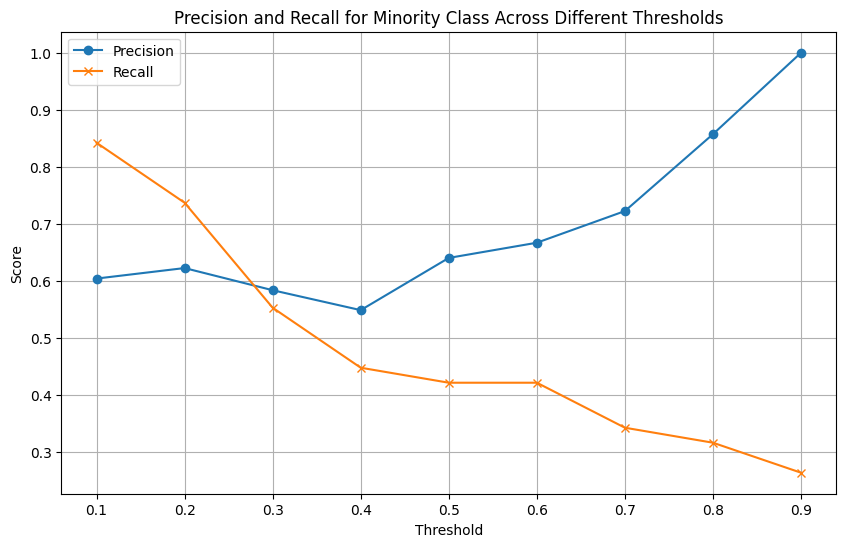

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred_proba are already defined from your model
# and the test data.

# Specify the thresholds you want to evaluate
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to hold precision and recall scores for the minority class
precision_minority = []
recall_minority = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision and recall for class 1 (the minority class in this scenario)
    precision_minority.append(precision_score(y_test, y_pred, pos_label=1))
    recall_minority.append(recall_score(y_test, y_pred, pos_label=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_minority, label='Precision', marker='o')
plt.plot(thresholds, recall_minority, label='Recall', marker='x')

plt.title('Precision and Recall for Minority Class Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

## Confustion Matrix

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       153
           1       0.54      0.55      0.55        38

    accuracy                           0.82       191
   macro avg       0.71      0.72      0.72       191
weighted avg       0.82      0.82      0.82       191



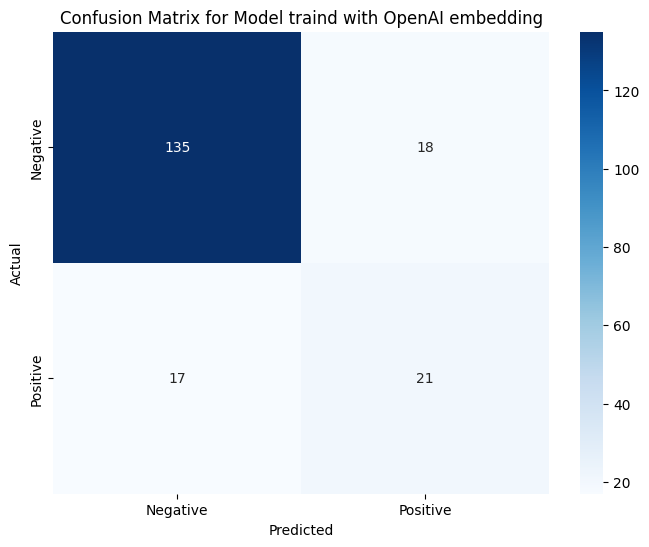

In [43]:
# Set the threshold
threshold = 0.3
y_pred = (y_pred_proba >= threshold).astype(int)
report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model traind with OpenAI embedding')
plt.show()

## Mixtral Expeiments - reading data and embedding

In [9]:
df_mixtral = pd.read_csv("/content/LJMU_Thesis/Processed_output/mixtral_generated_output.csv")


def get_embedding(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response['data'][0]['embedding']

df_mixtral['Embedding'] = df_mixtral['GeneratedText'].apply(get_embedding)

In [10]:
# df_mixtral.to_parquet('mixtral_embeddings.parquet', index=False)

parquet_file_path = '/content/LJMU_Thesis/Processed_output/mixtral_embeddings.parquet'
df_mixtral = pd.read_parquet(parquet_file_path)

## Mixtral modelling experiments

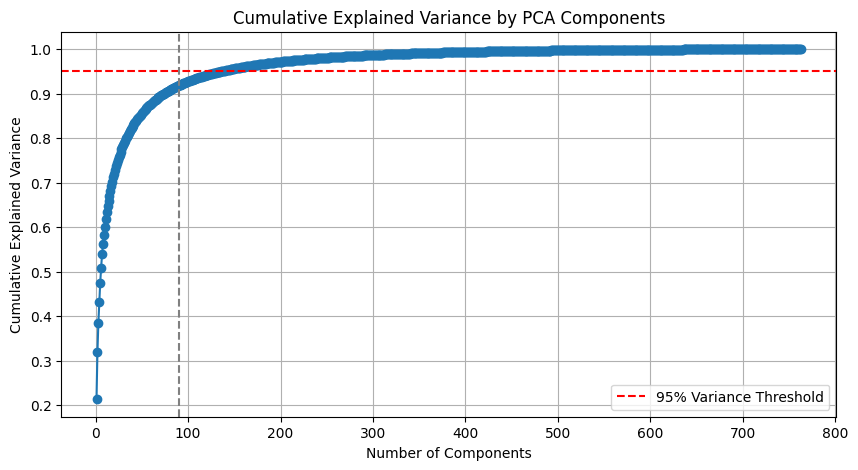

In [45]:
import matplotlib.pyplot as plt
# Prepare data
X = df_mixtral['Embedding'].tolist()
y = df_mixtral['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [46]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_mixtral['Embedding'].tolist(),
    df_mixtral['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       153
           1       0.70      0.18      0.29        38

    accuracy                           0.82       191
   macro avg       0.76      0.58      0.59       191
weighted avg       0.80      0.82      0.78       191



In [47]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model.fit(X_train_pca, y_train)
y_pred = xgb_model.predict(X_test_pca)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       153
           1       0.66      0.50      0.57        38

    accuracy                           0.85       191
   macro avg       0.77      0.72      0.74       191
weighted avg       0.84      0.85      0.84       191



In [48]:
y_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

Classification Report with Threshold 0.1:
              precision    recall  f1-score   support

           0       0.91      0.82      0.87       153
           1       0.49      0.68      0.57        38

    accuracy                           0.80       191
   macro avg       0.70      0.75      0.72       191
weighted avg       0.83      0.80      0.81       191


Classification Report with Threshold 0.2:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       153
           1       0.56      0.58      0.57        38

    accuracy                           0.83       191
   macro avg       0.73      0.73      0.73       191
weighted avg       0.83      0.83      0.83       191


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       153
           1       0.60      0.55      0.58        38

    accuracy                           0.84       191


## Buidling visuals

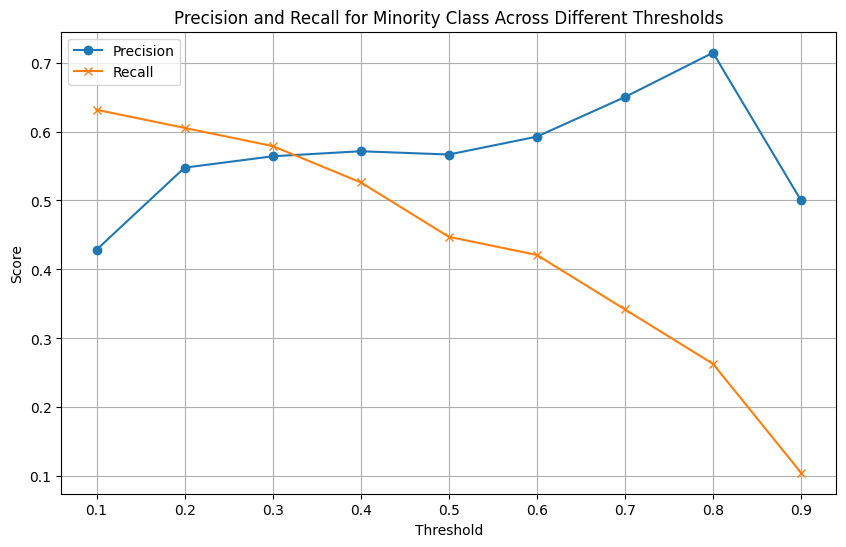

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred_proba are already defined from your model
# and the test data.

# Specify the thresholds you want to evaluate
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to hold precision and recall scores for the minority class
precision_minority = []
recall_minority = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision and recall for class 1 (the minority class in this scenario)
    precision_minority.append(precision_score(y_test, y_pred, pos_label=1))
    recall_minority.append(recall_score(y_test, y_pred, pos_label=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_minority, label='Precision', marker='o')
plt.plot(thresholds, recall_minority, label='Recall', marker='x')

plt.title('Precision and Recall for Minority Class Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

## Confustion Matrix

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       153
           1       0.62      0.55      0.58        38

    accuracy                           0.84       191
   macro avg       0.75      0.73      0.74       191
weighted avg       0.84      0.84      0.84       191



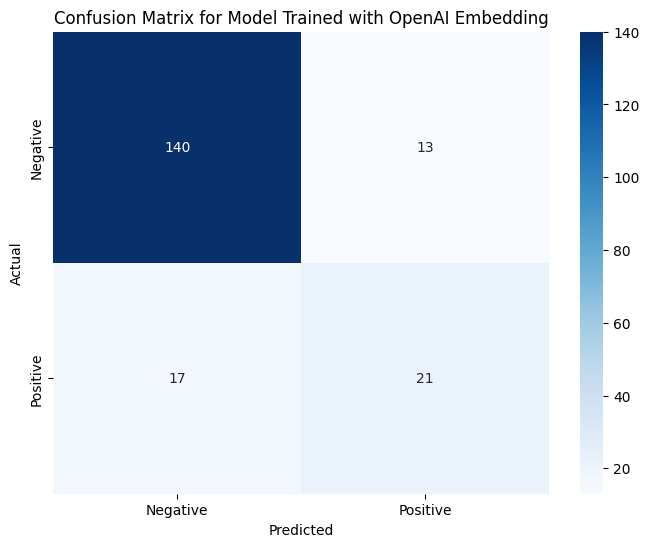

In [49]:
# Set the threshold
threshold = 0.32
y_pred = (y_pred_proba >= threshold).astype(int)
report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model Trained with OpenAI Embedding')
plt.show()

## LLama Experiments

In [13]:
# df_llama = pd.read_csv("/content/LJMU_Thesis/Processed_output/llama_generated_output.csv")

# df_llama['Embedding'] = df_llama['GeneratedText'].apply(get_embedding)

In [14]:
# df_llama.to_parquet('llama_embeddings.parquet', index=False)

parquet_file_path = '/content/LJMU_Thesis/Processed_output/llama_embeddings.parquet'
df_llama = pd.read_parquet(parquet_file_path)

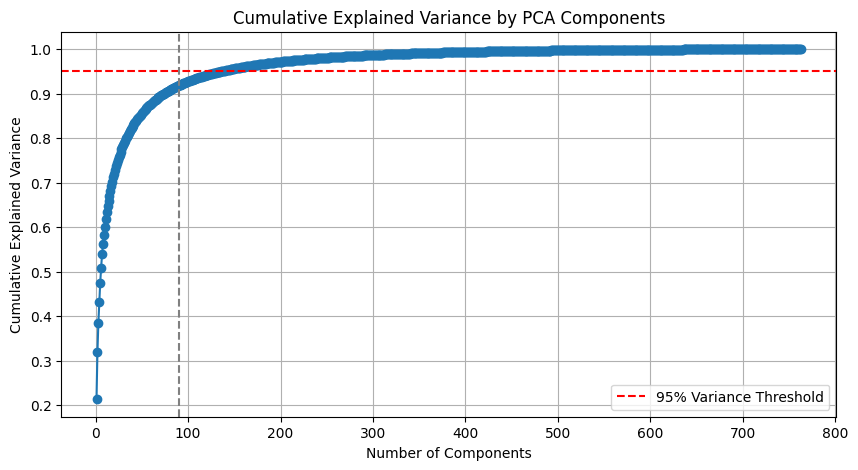

In [36]:
X = df_llama['Embedding'].tolist()
y = df_llama['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [51]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_mixtral['Embedding'].tolist(),
    df_mixtral['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model.fit(X_train_pca, y_train)
y_pred = xgb_model.predict(X_test_pca)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       153
           1       1.00      0.13      0.23        38

    accuracy                           0.83       191
   macro avg       0.91      0.57      0.57       191
weighted avg       0.86      0.83      0.77       191

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       153
           1       0.64      0.47      0.55        38

    accuracy                           0.84       191
   macro avg       0.76      0.70      0.73       191
weighted avg       0.83      0.84      0.83       191



In [52]:
y_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

Classification Report with Threshold 0.1:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       153
           1       0.47      0.74      0.57        38

    accuracy                           0.78       191
   macro avg       0.70      0.76      0.71       191
weighted avg       0.83      0.78      0.80       191


Classification Report with Threshold 0.2:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       153
           1       0.54      0.68      0.60        38

    accuracy                           0.82       191
   macro avg       0.73      0.77      0.74       191
weighted avg       0.84      0.82      0.83       191


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       153
           1       0.55      0.61      0.57        38

    accuracy                           0.82       191


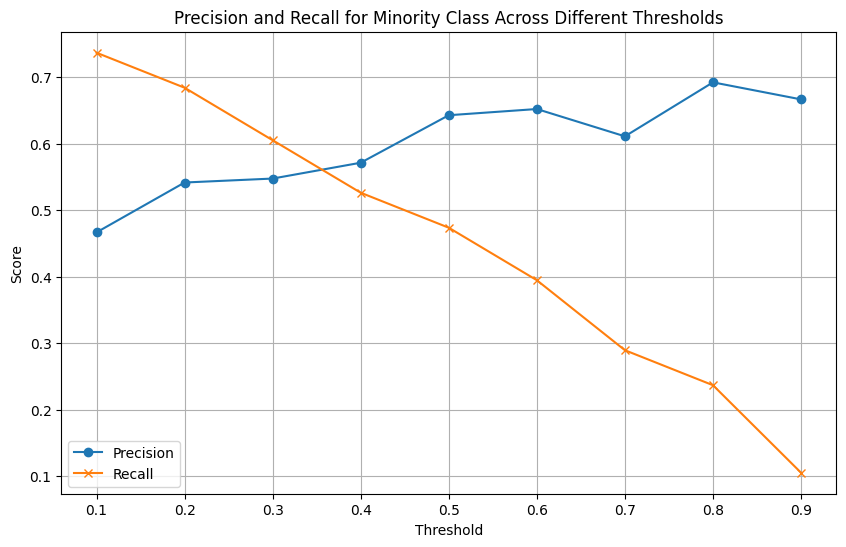

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred_proba are already defined from your model
# and the test data.

# Specify the thresholds you want to evaluate
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to hold precision and recall scores for the minority class
precision_minority = []
recall_minority = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision and recall for class 1 (the minority class in this scenario)
    precision_minority.append(precision_score(y_test, y_pred, pos_label=1))
    recall_minority.append(recall_score(y_test, y_pred, pos_label=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_minority, label='Precision', marker='o')
plt.plot(thresholds, recall_minority, label='Recall', marker='x')

plt.title('Precision and Recall for Minority Class Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

## Confustion Matrix

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       153
           1       0.55      0.58      0.56        38

    accuracy                           0.82       191
   macro avg       0.72      0.73      0.73       191
weighted avg       0.83      0.82      0.82       191



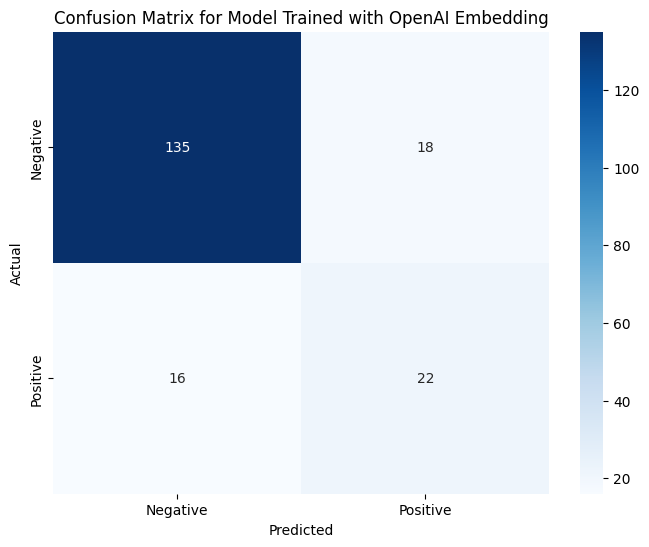

In [54]:
# Set the threshold
threshold = 0.32
y_pred = (y_pred_proba >= threshold).astype(int)
report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model Trained with OpenAI Embedding')
plt.show()